In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Use the actual notebook working directory
nb_dir = Path.cwd()
print(f"Current notebook path: {nb_dir}")

# Optionally add the notebook dir (for local-only imports)
if str(nb_dir) not in sys.path:
    sys.path.insert(0, str(nb_dir))
    print(f"Added {nb_dir} to sys.path")

# Critically: add the repository root so top-level packages like 'utils' are importable
# Notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration
# Repo root is two levels up: /home/luky/skola/KalmanNet-main
repo_root = nb_dir.parents[1]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f"Added {repo_root} to sys.path")

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


Načítám data z: ../preprocessed_NCLT_trajectory-2012-01-22...
✅ Data úspěšně načtena.
  -> Celkový počet vzorků: 5208
  -> Input Shape (Měření): torch.Size([5208, 4]) ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]
  -> Target Shape (GT):    torch.Size([5208, 4]) ... [PX, VX, PY, VY]


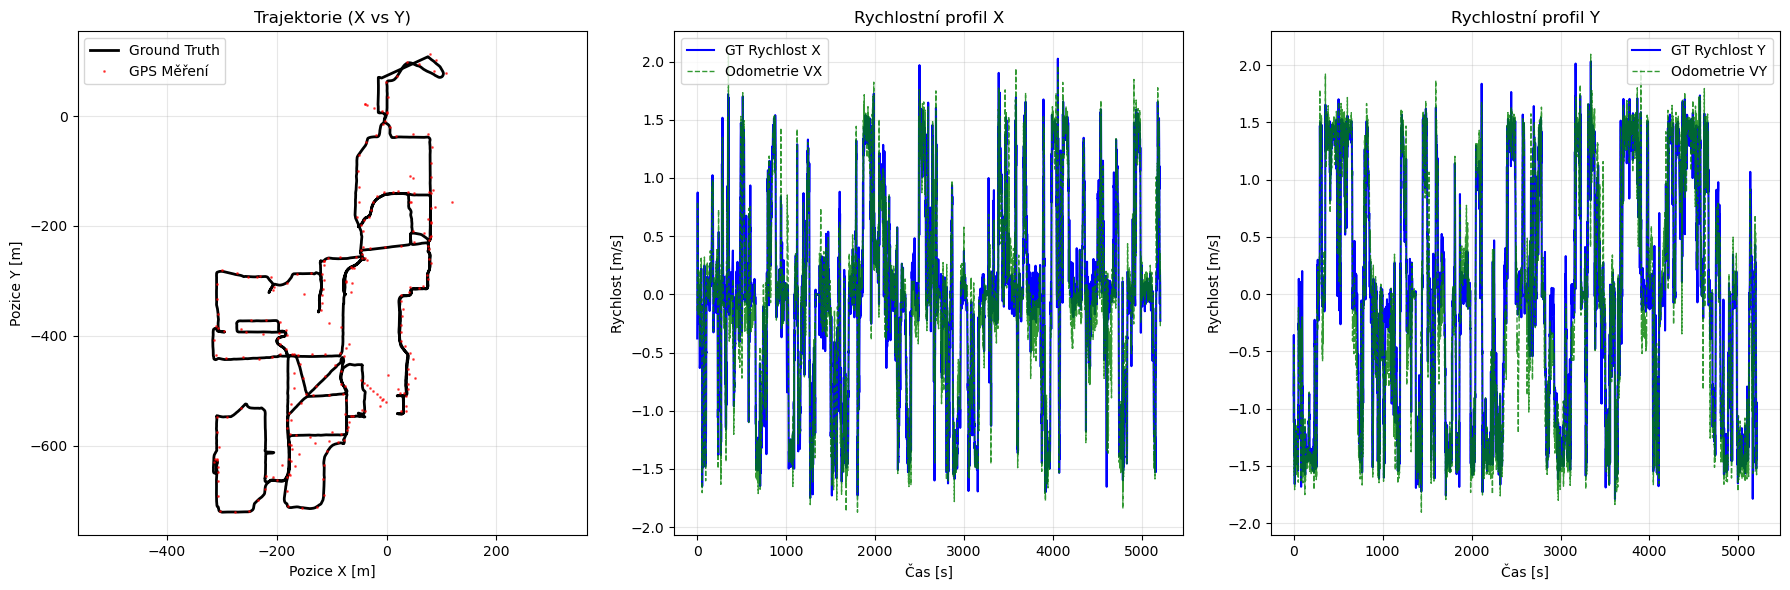

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

# === 1. KONFIGURACE ===
# Cesta k adresáři, který vytvořil preprocess skript
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22-angle-update'

print(f"Načítám data z: {data_dir}...")

try:
    # === 2. NAČTENÍ DAT (.pt soubory) ===
    # Data jsou uložena jako list slovníků [{'ground_truth': ..., 'filtered_gps': ...}]
    # filtered_gps zde ale obsahuje náš 4D vektor [GPS_X, ODO_VX, GPS_Y, ODO_VY]
    
    train_data = torch.load(os.path.join(data_dir, 'train.pt'))
    val_data = torch.load(os.path.join(data_dir, 'val.pt'))
    test_data = torch.load(os.path.join(data_dir, 'test.pt'))

    # Extrakce tensorů (předpokládáme 1 trajektorii v listu)
    X_train, Y_train = train_data[0]['ground_truth'], train_data[0]['filtered_gps']
    X_val, Y_val     = val_data[0]['ground_truth'],   val_data[0]['filtered_gps']
    X_test, Y_test   = test_data[0]['ground_truth'],  test_data[0]['filtered_gps']

    # Spojení zpět do jedné sekvence pro vizualizaci celé trajektorie
    X_full = torch.cat([X_train, X_val, X_test], dim=0)
    Y_full = torch.cat([Y_train, Y_val, Y_test], dim=0)

    print(f"✅ Data úspěšně načtena.")
    print(f"  -> Celkový počet vzorků: {X_full.shape[0]}")
    print(f"  -> Input Shape (Měření): {Y_full.shape} ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]")
    print(f"  -> Target Shape (GT):    {X_full.shape} ... [PX, VX, PY, VY]")

    # === 3. VIZUALIZACE ===
    # Převedeme na numpy pro matplotlib
    gt_np = X_full.numpy()
    meas_np = Y_full.numpy()
    time_steps = np.arange(len(gt_np)) # Předpoklad 1Hz (DT=1.0)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # --- A) Trajektorie (X-Y) ---
    # Ground Truth (Sloupce 0 a 2 v Targetu)
    ax[0].plot(gt_np[:, 0], gt_np[:, 2], 'k-', linewidth=2, label='Ground Truth')
    
    # GPS Měření (Sloupce 0 a 2 v Inputu)
    # Vykreslíme jen každý 20. bod, aby graf nebyl přeplácaný
    ax[0].plot(meas_np[::20, 0], meas_np[::20, 2], 'r.', markersize=2, alpha=0.6, label='GPS Měření')

    ax[0].set_title('Trajektorie (X vs Y)')
    ax[0].set_xlabel('Pozice X [m]')
    ax[0].set_ylabel('Pozice Y [m]')
    ax[0].axis('equal')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # --- B) Rychlost X (VX) ---
    # GT Rychlost (Sloupec 1 v Targetu)
    ax[1].plot(time_steps, gt_np[:, 1], 'b-', linewidth=1.5, label='GT Rychlost X')
    # ODO Rychlost (Sloupec 1 v Inputu)
    ax[1].plot(time_steps, meas_np[:, 1], 'g--', linewidth=1, alpha=0.8, label='Odometrie VX')

    ax[1].set_title('Rychlostní profil X')
    ax[1].set_xlabel('Čas [s]')
    ax[1].set_ylabel('Rychlost [m/s]')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # --- C) Rychlost Y (VY) ---
    # GT Rychlost (Sloupec 3 v Targetu)
    ax[2].plot(time_steps, gt_np[:, 3], 'b-', linewidth=1.5, label='GT Rychlost Y')
    # ODO Rychlost (Sloupec 3 v Inputu)
    ax[2].plot(time_steps, meas_np[:, 3], 'g--', linewidth=1, alpha=0.8, label='Odometrie VY')

    ax[2].set_title('Rychlostní profil Y')
    ax[2].set_xlabel('Čas [s]')
    ax[2].set_ylabel('Rychlost [m/s]')
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ CHYBA: Adresář '{data_dir}' nebo soubory .pt nenalezeny.")
    print("Spustil jsi předtím skript 'preprocess_NCLT_trajectory_linear_test.py'?")
except Exception as e:
    print(f"❌ CHYBA: {e}")

Načítám data pro vizualizaci z: ../preprocessed_NCLT_trajectory-2012-01-22...


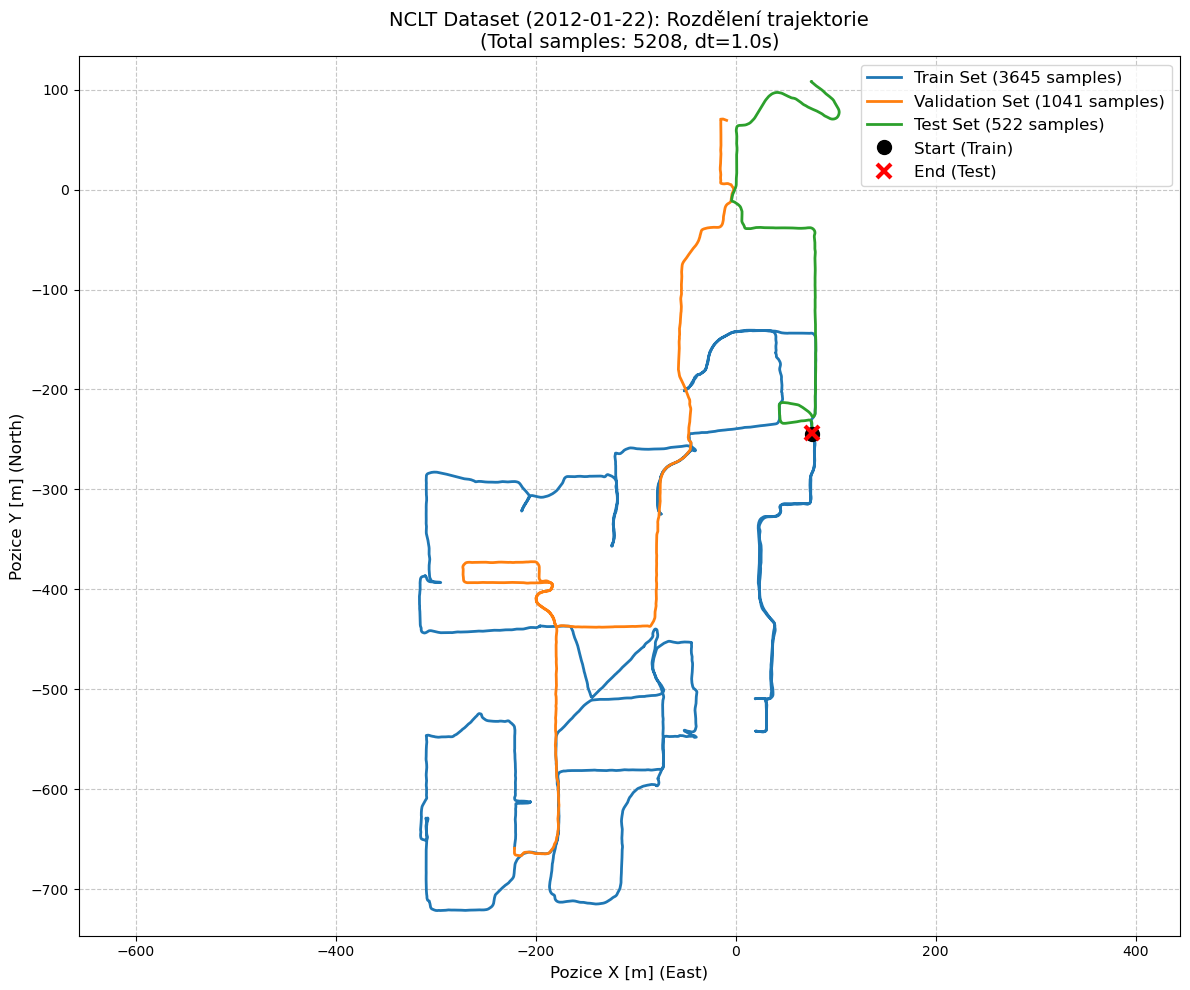

In [4]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

# === 1. NAČTENÍ DAT ===
# Cesta k adresáři s daty (musí odpovídat výstupu předchozího skriptu)
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22'

print(f"Načítám data pro vizualizaci z: {data_dir}...")

# Načtení listů (formát [{'ground_truth': ..., 'filtered_gps': ...}])
train_list = torch.load(os.path.join(data_dir, 'train.pt'))
val_list = torch.load(os.path.join(data_dir, 'val.pt'))
test_list = torch.load(os.path.join(data_dir, 'test.pt'))

# Extrakce Ground Truth tensorů (předpokládáme 1 souvislou trajektorii v indexu 0)
# GT formát: [px, vx, py, vy] -> X je index 0, Y je index 2
train_target = train_list[0]['ground_truth']
val_target   = val_list[0]['ground_truth']
test_target  = test_list[0]['ground_truth']

# Spočítáme celkový počet vzorků pro titulek
N_samples = len(train_target) + len(val_target) + len(test_target)
DT = 1.0 # Víme z konfigurace

# === 2. VIZUALIZACE ROZDĚLENÍ DATASETU ===

plt.figure(figsize=(12, 10))

# 1. Vykreslení Trénovací části (85%)
plt.plot(train_target[:, 0].numpy(), 
         train_target[:, 2].numpy(), 
         label=f'Train Set ({len(train_target)} samples)', color='#1f77b4', linewidth=2)

# 2. Vykreslení Validační části (10%)
plt.plot(val_target[:, 0].numpy(), 
         val_target[:, 2].numpy(), 
         label=f'Validation Set ({len(val_target)} samples)', color='#ff7f0e', linewidth=2)

# 3. Vykreslení Testovací části (5%)
plt.plot(test_target[:, 0].numpy(), 
         test_target[:, 2].numpy(), 
         label=f'Test Set ({len(test_target)} samples)', color='#2ca02c', linewidth=2)

# Zvýraznění začátku a konce
# Start (začátek tréninku)
plt.plot(train_target[0, 0], train_target[0, 2], 'ko', markersize=10, label='Start (Train)')
# End (konec testu)
plt.plot(test_target[-1, 0], test_target[-1, 2], 'rx', markersize=10, markeredgewidth=3, label='End (Test)')

# Formátování grafu
plt.title(f'NCLT Dataset (2012-01-22): Rozdělení trajektorie\n(Total samples: {N_samples}, dt={DT}s)', fontsize=14)
plt.xlabel('Pozice X [m] (East)', fontsize=12)
plt.ylabel('Pozice Y [m] (North)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Důležité: Aby mapa nebyla deformovaná

plt.tight_layout()
plt.show()

# Model definition

In [5]:
import torch
import math
import Systems # Tvůj modul s třídou DynamicSystem

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###################################################################
### Design Parameters - REAL SENSOR FUSION (NCLT Dataset)       ###
### Cíl: Fúze reálné GPS a Odometrie s optimálními parametry    ###
###################################################################

# 1. Rozměry
# Stav: [px, vx, py, vy] (Globální souřadnice)
m = 4 
n = 4 
delta_t = 1.0 # Sampling (1 Hz)

# 2. Dynamika (F) - Constant Velocity Model (Newton)
# x_{t+1} = x_t + v_t * dt
# v_{t+1} = v_t
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])

# Blokově diagonální pro X a Y: [[F, 0], [0, F]]
F_design = torch.block_diag(F_dim, F_dim).float()

# 3. Měření (H) - Identita
# Nyní měříme VŠECHNY stavy přímo:
# y = [gps_px, odo_vx, gps_py, odo_vy]
H_design = torch.eye(n).float()

# 4. Šum procesu (Q) - Fyzikální model
# Používáme "Discretized Continuous White Noise Acceleration" model.
# -------------------------------------------------------------------
# OPTIMALIZOVANÁ HODNOTA Z NCLT DAT (2012-01-22):
q_scale = 0.006697 
# -------------------------------------------------------------------

# Blok Q pro jednu dimenzi (pozice, rychlost)
Q_block = torch.tensor([[delta_t**3/3, delta_t**2/2],
                        [delta_t**2/2, delta_t]]) * q_scale

Q_design = torch.block_diag(Q_block, Q_block).float()

# 5. Šum měření (R) - Statistika z dat (Oracle)
# -------------------------------------------------------------------
# HODNOTY VYPOČTENÉ Z REZIDUÍ (Var = Std^2):
var_gps = 93.8867  # Odpovídá chybě cca 9.7 metrů
var_odo = 0.0440   # Odpovídá chybě cca 0.21 m/s
# -------------------------------------------------------------------

R_design = torch.tensor([[var_gps, 0.0,     0.0,     0.0],
                         [0.0,     var_odo, 0.0,     0.0],
                         [0.0,     0.0,     var_gps, 0.0],
                         [0.0,     0.0,     0.0,     var_odo]]).float()

# 6. Počáteční podmínky
# Inicializujeme na nule s rozumnou nejistotou
m1x_0 = torch.zeros(m, 1).float()
m2x_0 = torch.eye(m).float() * 10.0 # Větší nejistota na začátku (nevíme přesně kde jsme)

print("\nInicializuji systém pro REÁLNOU SENZORICKOU FÚZI (NCLT)...")
print(f"Dimenze stavu: {m}, Dimenze měření: {n}")
print(f"Použité Q scale: {q_scale}")
print(f"Použité R (diag): {torch.diagonal(R_design).numpy()}")

# === INICIALIZACE SYSTÉMŮ ===

# Sys True (V tomto reálném scénáři 'Sys True' neexistuje v generativním smyslu,
# protože data nepochází z tohoto modelu, ale z reality. Nicméně pro kompatibilitu
# s architekturou KalmanNetu ho definujeme stejně jako Model).
sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

# Sys Model (To, co používá filtr pro odhad)
sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

print("... Systémy inicializovány.")
print("Model je připraven na vstup: [GPS_X, ODO_VX, GPS_Y, ODO_VY]")


Inicializuji systém pro REÁLNOU SENZORICKOU FÚZI (NCLT)...
Dimenze stavu: 4, Dimenze měření: 4
Použité Q scale: 0.006697
Použité R (diag): [9.38867e+01 4.40000e-02 9.38867e+01 4.40000e-02]
... Systémy inicializovány.
Model je připraven na vstup: [GPS_X, ODO_VX, GPS_Y, ODO_VY]


In [6]:
import torch
import os
from torch.utils.data import TensorDataset, DataLoader

# === 0. NAČTENÍ PŘEDZPRACOVANÝCH DAT ===
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22-angle-update' # Uprav cestu dle potřeby
print(f"Načítám data z: {data_dir}...")

try:
    train_list = torch.load(os.path.join(data_dir, 'train.pt'))
    val_list = torch.load(os.path.join(data_dir, 'val.pt'))
    test_list = torch.load(os.path.join(data_dir, 'test.pt'))

    # Extrakce tensorů
    train_target = train_list[0]['ground_truth'].float()
    val_target   = val_list[0]['ground_truth'].float()
    test_target  = test_list[0]['ground_truth'].float()

    train_input  = train_list[0]['filtered_gps'].float()
    val_input    = val_list[0]['filtered_gps'].float()
    test_input   = test_list[0]['filtered_gps'].float()

    print(f"Data načtena. Train: {len(train_target)}, Val: {len(val_target)}, Test: {len(test_target)}")

except FileNotFoundError:
    raise FileNotFoundError(f"Chybí data v {data_dir}.")

# === 1. KONFIGURACE ===
# Zde je ta změna:
TRAIN_SEQ_LEN = 50      # Krátké pro rychlý backprop
VAL_SEQ_LEN = 200       # Střední pro stabilní validaci (místo celé délky)
TEST_SEQ_LEN = len(test_target) # Test necháme celý pro finální "pravdu"

STRIDE_TRAIN = 5        # Překryv u tréninku (Data Augmentation)
STRIDE_VAL = 30        # Bez překryvu u validace (chceme nezávislé úseky)

BATCH_SIZE = 128

def create_sequences(X, Y, seq_len, stride=1):
    """
    Rozseká dlouhé tenzory na sekvence.
    """
    xs = []
    ys = []
    num_samples = X.shape[0]
    
    # Pokud je požadovaná délka delší než data, vrátíme co máme (pro Test)
    if seq_len >= num_samples:
        return X.unsqueeze(0), Y.unsqueeze(0)
    
    # Sekání
    for i in range(0, num_samples - seq_len + 1, stride):
        x_seq = X[i : i+seq_len, :]
        y_seq = Y[i : i+seq_len, :]
        xs.append(x_seq)
        ys.append(y_seq)
        
    if len(xs) == 0:
        return torch.empty(0, seq_len, X.shape[1]), torch.empty(0, seq_len, Y.shape[1])
        
    return torch.stack(xs), torch.stack(ys)

def clean_sequences(X_seq, Y_seq, name="Dataset"):
    if X_seq.numel() == 0:
        print(f"⚠️ {name}: Prázdný vstup!")
        return X_seq, Y_seq

    # Kontrola NaN/Inf
    is_nan_x = torch.isnan(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_inf_x = torch.isinf(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_nan_y = torch.isnan(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    is_inf_y = torch.isinf(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    
    invalid_mask = is_nan_x | is_inf_x | is_nan_y | is_inf_y
    valid_mask = ~invalid_mask
    
    X_clean = X_seq[valid_mask]
    Y_clean = Y_seq[valid_mask]
    
    n_dropped = invalid_mask.sum().item()
    if n_dropped > 0:
        print(f"⚠️ {name}: Odstraněno {n_dropped} vadných sekvencí.")
    else:
        print(f"✅ {name}: Data jsou čistá. ({len(X_clean)} sekvencí)")
        
    return X_clean, Y_clean

print("\n--- ZPRACOVÁNÍ SEKVENCÍ ---")

# === 2. TVORBA SEKVENCÍ ===
print(f"Generuji TRAIN sekvence (Len={TRAIN_SEQ_LEN}, Stride={STRIDE_TRAIN})...")
train_X_raw, train_Y_raw = create_sequences(train_target, train_input, TRAIN_SEQ_LEN, STRIDE_TRAIN)

# ZMĚNA: Validace už není jedna dlouhá nudle, ale sada 1000-krokových úseků
print(f"Generuji VAL sekvence (Len={VAL_SEQ_LEN}, Stride={STRIDE_VAL})...")
val_X_raw, val_Y_raw = create_sequences(val_target, val_input, VAL_SEQ_LEN, STRIDE_VAL)

print(f"Generuji TEST sekvence (Full trajectory)...")
test_X_raw, test_Y_raw = create_sequences(test_target, test_input, TEST_SEQ_LEN, TEST_SEQ_LEN)

# === 3. ČIŠTĚNÍ DAT ===
train_X_seq, train_Y_seq = clean_sequences(train_X_raw, train_Y_raw, "Train")
val_X_seq, val_Y_seq = clean_sequences(val_X_raw, val_Y_raw, "Val")
test_X_seq, test_Y_seq = clean_sequences(test_X_raw, test_Y_raw, "Test")

# === 4. VYTVOŘENÍ DATALOADERŮ ===
print("\nVytvářím DataLoadery...")

train_dataset = TensorDataset(train_X_seq, train_Y_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val: Batch size může být nyní větší než 1, protože máme více sekvencí stejné délky!
# To zrychlí validaci.
val_dataset = TensorDataset(val_X_seq, val_Y_seq)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_X_seq, test_Y_seq)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"\n✅ HOTOVO.")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)} (Délka každé sekvence: {VAL_SEQ_LEN})")
print(f"Test samples:  {len(test_dataset)} (Celá trajektorie)")

Načítám data z: ../preprocessed_NCLT_trajectory-2012-01-22-angle-update...
Data načtena. Train: 3645, Val: 1041, Test: 522

--- ZPRACOVÁNÍ SEKVENCÍ ---
Generuji TRAIN sekvence (Len=50, Stride=5)...
Generuji VAL sekvence (Len=200, Stride=30)...
Generuji TEST sekvence (Full trajectory)...
✅ Train: Data jsou čistá. (720 sekvencí)
✅ Val: Data jsou čistá. (29 sekvencí)
✅ Test: Data jsou čistá. (1 sekvencí)

Vytvářím DataLoadery...

✅ HOTOVO.
Train samples: 720
Val samples:   29 (Délka každé sekvence: 200)
Test samples:  1 (Celá trajektorie)


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def train_BayesianKalmanNet_Hybrid(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period,
    warmup_iterations=0, weight_decay_=1e-5,
    lambda_mse=100.0  # <--- NOVÝ PARAMETR: Kotva pro MSE
):
    # torch.autograd.set_detect_anomaly(True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    # Scheduler: Pokud se loss zasekne, snížíme LR (pomáhá stabilizovat konvergenci)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=50, verbose=True
    )

    best_val_anees = float('inf')
    score_at_best = {"val_nll": 0.0, "val_mse": 0.0}
    best_iter_count = 0
    best_model_state = None
    train_iter_count = 0
    done = False

    print(f"🚀 START Hybrid Training: Loss = NLL + {lambda_mse} * MSE")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            if torch.isnan(x_true_batch).any():
                print(f"!!! SKIP BATCH iter {train_iter_count}: NaN found in x_true (Ground Truth) !!!")
                continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            # --- Training ---
            optimizer.zero_grad()
            batch_size, seq_len, _ = x_true_batch.shape
            
            all_trajectories_for_ensemble = []
            all_regs_for_ensemble = []

            # 1. Ensemble Forward Pass
            for j in range(J_samples):
                model.reset(batch_size=batch_size, initial_state=x_true_batch[:, 0, :])
                current_trajectory_x_hats = []
                current_trajectory_regs = []
                for t in range(1, seq_len):
                    y_t = y_meas_batch[:, t, :]
                    x_filtered_t, reg_t = model.step(y_t)
                    if torch.isnan(x_filtered_t).any():
                            raise ValueError(f"NaN in x_filtered_t at sample {j}, step {t}")
                    current_trajectory_x_hats.append(x_filtered_t)
                    current_trajectory_regs.append(reg_t)
                all_trajectories_for_ensemble.append(torch.stack(current_trajectory_x_hats, dim=1))
                all_regs_for_ensemble.append(torch.sum(torch.stack(current_trajectory_regs)))

            # 2. Statistiky Ensemble
            ensemble_trajectories = torch.stack(all_trajectories_for_ensemble, dim=0)
            x_hat_sequence = ensemble_trajectories.mean(dim=0)
            
            # Epistemická variance (čistý rozptyl sítě)
            # Přičítáme 1e-9 jen proti dělení nulou, není to "noise floor"
            cov_diag_sequence = ensemble_trajectories.var(dim=0) + 1e-9 
            
            regularization_loss = torch.stack(all_regs_for_ensemble).mean()
            target_sequence = x_true_batch[:, 1:, :]
            
            # --- 3. VÝPOČET HYBRIDNÍ LOSS ---
            
            # A) MSE Část (Přesnost)
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            
            # B) NLL Část (Konzistence)
            # 0.5 * (log(var) + (target - pred)^2 / var)
            error_sq = (x_hat_sequence - target_sequence) ** 2
            nll_loss = 0.5 * (torch.log(cov_diag_sequence) + error_sq / cov_diag_sequence).mean()
            
            # C) Celková Loss (Hybrid)
            # Zde je ta magie: I když NLL chce utéct s variancí, lambda_mse * mse ho drží zpátky
            loss = nll_loss + (lambda_mse * mse_loss) + regularization_loss * 1.0
            
            if torch.isnan(loss): 
                print("Collapse detected (NaN loss)"); done = True; break
            
            loss.backward()
            if clip_grad > 0: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            train_iter_count += 1
            
            # --- Logging ---
            diff = x_hat_sequence - target_sequence
            mean_error = diff.abs().mean().item()
            min_variance = cov_diag_sequence.min().item()

            if train_iter_count % logging_period == 0:
                with torch.no_grad():
                    # Zjistíme dropout pravděpodobnosti (jen pro info)
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                
                print(f"--- Iter [{train_iter_count}/{total_train_iter}] ---")
                print(f"    Total Loss: {loss.item():.4f}")
                print(f"    MSE Component: {mse_loss.item():.4f} (Weighted: {(mse_loss.item() * lambda_mse):.4f})")
                print(f"    NLL Component: {nll_loss.item():.4f}")
                print(f"    Min Variance: {min_variance:.2e}")
                print(f"    p1={p1:.3f}, p2={p2:.3f}")

            # --- Validation step ---
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                # Step scheduleru podle trénovací loss (nebo validace, pokud bys to předělal)
                scheduler.step(loss)
                
                print(f"\n--- Validation at iteration {train_iter_count} ---")
                model.eval()
                val_mse_list = []
                all_val_x_true_cpu, all_val_x_hat_cpu, all_val_P_hat_cpu = [], [], []

                with torch.no_grad():
                    for x_true_val_batch, y_meas_val_batch in val_loader:
                        val_batch_size, val_seq_len, _ = x_true_val_batch.shape
                        x_true_val_batch = x_true_val_batch.to(device)
                        y_meas_val_batch = y_meas_val_batch.to(device)
                        val_ensemble_trajectories = []
                        for j in range(J_samples):
                            model.reset(batch_size=val_batch_size, initial_state=x_true_val_batch[:, 0, :])
                            val_current_x_hats = []
                            for t in range(1, val_seq_len):
                                y_t_val = y_meas_val_batch[:, t, :]
                                x_filtered_t, _ = model.step(y_t_val)
                                val_current_x_hats.append(x_filtered_t)
                            val_ensemble_trajectories.append(torch.stack(val_current_x_hats, dim=1))
                        
                        # Agregace validace
                        val_ensemble = torch.stack(val_ensemble_trajectories, dim=0)
                        val_preds_seq = val_ensemble.mean(dim=0)
                        
                        val_target_seq = x_true_val_batch[:, 1:, :]
                        val_mse_list.append(F.mse_loss(val_preds_seq, val_target_seq).item())
                        
                        # Příprava pro ANEES
                        initial_state_val = x_true_val_batch[:, 0, :].unsqueeze(1)
                        full_x_hat = torch.cat([initial_state_val, val_preds_seq], dim=1)
                        
                        # Epistemická variance
                        val_covs_diag = val_ensemble.var(dim=0) + 1e-9
                        
                        # Vytvoření diagonálních matic P
                        # (Zjednodušená konstrukce pro ANEES calc)
                        # Pro přesné ANEES bychom měli dělat outer product, 
                        # ale diagonála z var() je dobrá aproximace pro BKN
                        val_covs_full = torch.zeros(val_batch_size, val_seq_len-1, 4, 4, device=device)
                        for b in range(val_batch_size):
                            for t in range(val_seq_len-1):
                                val_covs_full[b, t] = torch.diag(val_covs_diag[b, t])

                        P0 = model.system_model.P0.unsqueeze(0).repeat(val_batch_size, 1, 1).unsqueeze(1)
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true_cpu.append(x_true_val_batch.cpu())
                        all_val_x_hat_cpu.append(full_x_hat.cpu())
                        all_val_P_hat_cpu.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                final_x_true_list = torch.cat(all_val_x_true_cpu, dim=0)
                final_x_hat_list = torch.cat(all_val_x_hat_cpu, dim=0)
                final_P_hat_list = torch.cat(all_val_P_hat_cpu, dim=0)
                
                # Výpočet ANEES
                avg_val_anees = trainer.calculate_anees_vectorized(final_x_true_list, final_x_hat_list, final_P_hat_list)
                
                print(f"  Average MSE: {avg_val_mse:.4f}, Average ANEES: {avg_val_anees:.4f}")
                
                # Ukládání modelu:
                # ZDE POZOR: Ukládáme, pokud je ANEES rozumné A ZÁROVEŇ MSE není katastrofické.
                # Nebo prostě ukládáme podle nejlepšího ANEES jako dřív, ale s vědomím hybridní loss.
                if not np.isnan(avg_val_anees) and avg_val_anees < best_val_anees and avg_val_anees > 0:
                    print("  >>> New best VALIDATION ANEES! Saving model. <<<")
                    best_val_anees = avg_val_anees
                    best_iter_count = train_iter_count
                    score_at_best['val_mse'] = avg_val_mse
                    best_model_state = deepcopy(model.state_dict())
                print("-" * 50)
                model.train()

    print("\nTraining completed.")
    if best_model_state:
        print(f"Loading best model from iteration {best_iter_count} with ANEES {best_val_anees:.4f}")
        model.load_state_dict(best_model_state)
    else:
        print("No best model was saved; returning last state.")

    return {
        "best_val_anees": best_val_anees,
        "best_val_nll": score_at_best['val_nll'],
        "best_val_mse": score_at_best['val_mse'],
        "best_iter": best_iter_count,
        "final_model": model
    }

In [8]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
from state_NN_models import StateBayesianKalmanNet

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
# Změny v parametrech
state_knet = StateBayesianKalmanNet(
    sys_model, 
    device=device, 
    hidden_size_multiplier=10,       # Necháme
    output_layer_multiplier=4, 
    num_gru_layers=1,
    init_max_dropout=0.3,           # <--- SNÍŽENO (bylo 0.6)
    init_min_dropout=0.1,           # <--- SNÍŽENO (bylo 0.4)
    norm_states=True                # Pokud ti to s tím minule běželo, nech to, 
                                    # ale LayerNorm v síti musí být!
).to(device)

train_BayesianKalmanNet_Hybrid(
    model=state_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    total_train_iter=2000,          # Mírně delší
    learning_rate=1e-4,             # <--- Mírně zvýšeno pro dynamiku
    warmup_iterations=0,          # <--- PRODLOUŽENO (důležité pro MSE)
    clip_grad=1.0,                  # Uvolníme trochu gradienty
    J_samples=7,                    # Pro rychlost ladění stačí 5, na finále dej 10+
    validation_period=10,
    logging_period=1,
    weight_decay_=1e-3,
    lambda_mse=1000.0                # <--- NOVÝ PARAMETR: Kotva pro MSE
)

INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).


/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


🚀 START Hybrid Training: Loss = NLL + 1000.0 * MSE
--- Iter [1/2000] ---
    Total Loss: 354432.2812
    MSE Component: 353.9893 (Weighted: 353989.3188)
    NLL Component: 442.8661
    Min Variance: 4.27e-07
    p1=0.258, p2=0.233
--- Iter [2/2000] ---
    Total Loss: 360292.0312
    MSE Component: 359.7486 (Weighted: 359748.5962)
    NLL Component: 543.3486
    Min Variance: 4.02e-07
    p1=0.258, p2=0.233
--- Iter [3/2000] ---
    Total Loss: 698427.4375
    MSE Component: 697.7944 (Weighted: 697794.3726)
    NLL Component: 632.9862
    Min Variance: 5.44e-08
    p1=0.258, p2=0.233
--- Iter [4/2000] ---
    Total Loss: 838212.1250
    MSE Component: 837.6701 (Weighted: 837670.1050)
    NLL Component: 541.9357
    Min Variance: 4.00e-07
    p1=0.258, p2=0.233
--- Iter [5/2000] ---
    Total Loss: 481844.5625
    MSE Component: 481.3866 (Weighted: 481386.5967)
    NLL Component: 457.8594
    Min Variance: 1.14e-07
    p1=0.258, p2=0.233
--- Iter [6/2000] ---
    Total Loss: 680335.5000

{'best_val_anees': 60.49876022338867,
 'best_val_nll': 0.0,
 'best_val_mse': 488.4022216796875,
 'best_iter': 2000,
 'final_model': StateBayesianKalmanNet(
   (dnn): DNN_BayesianKalmanNet(
     (input_layer): Sequential(
       (0): Linear(in_features=16, out_features=640, bias=True)
       (1): ReLU()
     )
     (concrete_dropout1): ConcreteDropout()
     (gru): GRU(640, 128)
     (output_layer): Sequential(
       (0): Linear(in_features=128, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=16, bias=True)
     )
     (concrete_dropout2): ConcreteDropout()
   )
 )}

In [ ]:
if False:
    import torch
    import os

    # Protože jsi trénink přerušil, nemáme slovník s metrikami automaticky.
    # Musíme uložit přímo model 'state_knet'.

    # 1. Definuj cestu (Metriky si do názvu musíš dopsat ručně podle toho, co jsi viděl v logu naposledy,
    # nebo použij obecný název, abys o model nepřišel).
    save_path = 'best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth'

    # Pokud si pamatuješ hodnoty z logu (např. ANEES 23.5), můžeš je tam dopsat ručně:
    # save_path = 'best_kalmannet_nclt_sensor_fusion_ANEES23.57_MSE8.17_interrupted.pth'

    # 2. Uložení
    # DŮLEŽITÉ: Voláme .state_dict() přímo na objektu state_knet (nebo trained_knet, pokud jsi ho přiřadil)
    # Nepoužíváme závorky ['final_model'], protože state_knet UŽ JE ten model.
    torch.save(state_knet.state_dict(), save_path)

    print(f"\n✅ Záchrana modelu úspěšná! Uloženo do: {save_path}")

if False:
    import os
    # trained_knet = state_knet 
    # Přístup k metrikám ve slovníku je správně (přes závorky [])
    print(f"   -> Best ANEES: {trained_knet['best_val_anees']:.4f}")
    print(f"   -> Best MSE:   {trained_knet['best_val_mse']:.4f}")
    save_path = f'best_kalmanFormer_nclt_sensor_fusion_ANEES{trained_knet["best_val_anees"]:.4f}_MSE{trained_knet["best_val_mse"]:.4f}_nejlepsi_test_vysledky.pth '

    # OPRAVA: Musíš vytáhnout model ze slovníku pomocí klíče 'final_model'
    # A teprve na něm zavolat .state_dict()
    torch.save(trained_knet['final_model'].state_dict(), save_path)

    print(f"\n✅ Model úspěšně uložen do: {save_path}")



✅ Záchrana modelu úspěšná! Uloženo do: best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth


In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  
from utils import utils 

# ==============================================================================
# 0. KONFIGURACE A PŘÍPRAVA MODELŮ
# ==============================================================================
# Parametry pro Bayesovskou inferenci
J_SAMPLES_TEST = 20       # Počet vzorků pro Ensemble

try:
    trained_model_bkn = state_knet
    # DŮLEŽITÉ: Necháme model v módu .train(), aby fungoval Dropout pro Ensemble
    trained_model_bkn.train() 
    
    print(f"INFO: BayesianKalmanNet připraven (Ensemble size={J_SAMPLES_TEST}, BEZ Noise Floor).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_knet' neexistuje. Spusťte nejprve trénink.")

# Inicializace klasických filtrů
print("Inicializuji EKF, UKF, PF, AKF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)
pf_filter = Filters.ParticleFilter(sys_model, num_particles=10000) 
akf_filter = Filters.AdaptiveKalmanFilter(sys_model, mdm_L=4, mdm_version=1)
kf_filter = Filters.KalmanFilter(sys_model)

# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Seznamy pro ukládání výsledků
mse_knet, anees_knet = [], []
mse_ekf, anees_ekf = [], []
mse_ukf, anees_ukf = [], []
mse_pf, anees_pf = [], []
mse_akf, anees_akf = [], []
mse_kf, anees_kf = [], []

# Počítadla
traj_idx = 0
total_trajectories = len(test_loader.dataset)

print(f"\nVyhodnocuji {total_trajectories} sekvencí z testovací sady...")

with torch.no_grad():
    for x_true_batch, y_meas_batch in test_loader:
        
        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            traj_idx += 1
            
            # Příprava dat pro jednu trajektorii
            y_seq = y_meas_batch[i].to(device)    # [Seq_Len, Obs_Dim]
            x_true = x_true_batch[i].to(device)   # [Seq_Len, State_Dim]
            seq_len = y_seq.shape[0]

            # --- PŘÍPRAVA POČÁTEČNÍHO STAVU ---
            knet_init_state = x_true[0, :].unsqueeze(0) # [1, Dim]
            filter_init_state = x_true[0, :].unsqueeze(1) # [Dim, 1]

            # ==================================================================
            # A. Bayesian KalmanNet (Ensemble Inference)
            # ==================================================================
            ensemble_preds = []
            
            # 1. Generování J trajektorií (Monte Carlo)
            for j in range(J_SAMPLES_TEST):
                trained_model_bkn.reset(batch_size=1, initial_state=knet_init_state)
                
                # Uložíme predikce pro tento sample
                sample_seq = [knet_init_state] 
                
                for t in range(1, seq_len):
                    y_t = y_seq[t, :].unsqueeze(0)
                    # U BKN step vrací (x, reg), reg nás při testu nezajímá
                    x_val, _ = trained_model_bkn.step(y_t) 
                    sample_seq.append(x_val)
                
                # Spojíme do [Seq_Len, State_Dim]
                ensemble_preds.append(torch.cat(sample_seq, dim=0))
            
            # 2. Statistiky Ensemble (Mean & Variance)
            # Shape: [J, Seq_Len, State_Dim]
            ensemble_tensor = torch.stack(ensemble_preds, dim=0)
            
            # Průměrná trajektorie (Očekávaná hodnota)
            full_x_hat_knet = ensemble_tensor.mean(dim=0) 
            
            # Variace modelu (Epistemická nejistota)
            # ZDE JE ZMĚNA: Žádný sensor_noise_floor, bereme čistý rozptyl sítě
            total_var = ensemble_tensor.var(dim=0)
            
            # Konstrukce plné kovarianční matice P (Diagonal)
            # ANEES vyžaduje [Seq_Len, State_Dim, State_Dim]
            full_P_hat_knet = torch.zeros(seq_len, m, m, device=device)
            for t_step in range(seq_len):
                # Přidáme malé epsilon pro numerickou stabilitu, kdyby byl rozptyl 0
                full_P_hat_knet[t_step] = torch.diag(total_var[t_step] + 1e-9)

            # ==================================================================
            # B. Klasické Filtry
            # ==================================================================
            
            # Adaptive KF
            akf_m_res,_,_ = akf_filter.process_sequence_adaptively(y_seq)
            full_x_hat_akf = akf_m_res['x_filtered']
            full_P_hat_akf = akf_m_res['P_filtered']

            # EKF
            ekf_res = ekf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_ekf = ekf_res['x_filtered']
            full_P_hat_ekf = ekf_res['P_filtered']

            # UKF
            ukf_res = ukf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_ukf = ukf_res['x_filtered']
            full_P_hat_ukf = ukf_res['P_filtered']

            # PF
            pf_res = pf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_pf = pf_res['x_filtered']
            full_P_hat_pf = pf_res['P_filtered']

            # Standard KF
            kf_res = kf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_kf = kf_res['x_filtered']
            full_P_hat_kf = kf_res['P_filtered']
            
            # ==================================================================
            # C. Metriky
            # ==================================================================
            # 1. MSE
            mse_knet.append(F.mse_loss(full_x_hat_knet[1:], x_true[1:]).item())
            mse_ekf.append(F.mse_loss(full_x_hat_ekf[1:], x_true[1:]).item())
            mse_ukf.append(F.mse_loss(full_x_hat_ukf[1:], x_true[1:]).item())
            mse_pf.append(F.mse_loss(full_x_hat_pf[1:], x_true[1:]).item())
            mse_akf.append(F.mse_loss(full_x_hat_akf[1:], x_true[1:]).item())
            mse_kf.append(F.mse_loss(full_x_hat_kf[1:], x_true[1:]).item())

            # 2. ANEES
            def calc_anees_traj(x_true_seq, x_hat_seq, P_hat_seq):
                return utils.calculate_anees_vectorized(
                    x_true_seq.unsqueeze(0).cpu(), 
                    x_hat_seq.unsqueeze(0).cpu(), 
                    P_hat_seq.unsqueeze(0).cpu()
                )

            anees_knet.append(calc_anees_traj(x_true, full_x_hat_knet, full_P_hat_knet))
            anees_ekf.append(calc_anees_traj(x_true, full_x_hat_ekf, full_P_hat_ekf))
            anees_ukf.append(calc_anees_traj(x_true, full_x_hat_ukf, full_P_hat_ukf))
            anees_pf.append(calc_anees_traj(x_true, full_x_hat_pf, full_P_hat_pf))
            anees_akf.append(calc_anees_traj(x_true, full_x_hat_akf, full_P_hat_akf))
            anees_kf.append(calc_anees_traj(x_true, full_x_hat_kf, full_P_hat_kf))

            if traj_idx % 20 == 0:
                print(f"  -> Zpracováno {traj_idx}/{total_trajectories}")

# ==============================================================================
# 2. FINÁLNÍ VÝPIS
# ==============================================================================
def avg(lst): return np.mean(lst) if len(lst) > 0 else 0.0

state_dim = sys_model.state_dim

print("\n" + "="*90)
print(f"FINÁLNÍ VÝSLEDKY: BAYESIAN KALMANNET (PURE EPISTEMIC) vs CLASSIC FILTERS")
print("="*90)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 90)
print(f"Cílové ANEES ≈ {state_dim:.2f}")
print("-" * 90)

print(f"{'Bayesian KalmanNet (Ensemble)':<35} | {avg(mse_knet):<20.4f} | {avg(anees_knet):<20.4f}")
print(f"{'Adaptive KF':<35} | {avg(mse_akf):<20.4f} | {avg(anees_akf):<20.4f}")
print(f"{'Extended KF (EKF)':<35} | {avg(mse_ekf):<20.4f} | {avg(anees_ekf):<20.4f}")
print(f"{'Unscented KF (UKF)':<35} | {avg(mse_ukf):<20.4f} | {avg(anees_ukf):<20.4f}")
print(f"{'Standard KF (Ideal Baseline)':<35} | {avg(mse_kf):<20.4f} | {avg(anees_kf):<20.4f}")
print(f"{'Particle Filter':<35} | {avg(mse_pf):<20.4f} | {avg(anees_pf):<20.4f}")
print("="*90)

INFO: BayesianKalmanNet připraven (Ensemble size=20, BEZ Noise Floor).
Inicializuji EKF, UKF, PF, AKF...

Vyhodnocuji 1 sekvencí z testovací sady...
Spouštím MDM odhad Q a R...
MDM odhad dokončen.
Odhadnuté Q:
 [[ 4.13064070e-01 -4.24937501e-02 -5.86073509e-02  1.48873742e-02]
 [-4.24937501e-02  2.73768306e-02  1.39817027e-02 -6.98700785e-05]
 [-5.86073509e-02  1.39817027e-02  3.34790303e-01 -3.45426741e-02]
 [ 1.48873742e-02 -6.98700785e-05 -3.45426741e-02  2.28525577e-02]]
Odhadnuté R:
 [[-1.46430036e-01  1.51903669e-02  2.63280698e-02 -6.06997575e-03]
 [ 1.51903669e-02  1.79104244e-02  1.22167787e-04 -7.55524608e-03]
 [ 2.63280698e-02  1.22167787e-04 -1.19015472e-01  1.38572726e-02]
 [-6.06997575e-03 -7.55524608e-03  1.38572726e-02  1.32357773e-02]]
Matice Q a R v Kalmanově filtru byly aktualizovány.

FINÁLNÍ VÝSLEDKY: BAYESIAN KALMANNET (PURE EPISTEMIC) vs CLASSIC FILTERS
Model                               | Průměrné MSE         | Průměrný ANEES      
-----------------------------

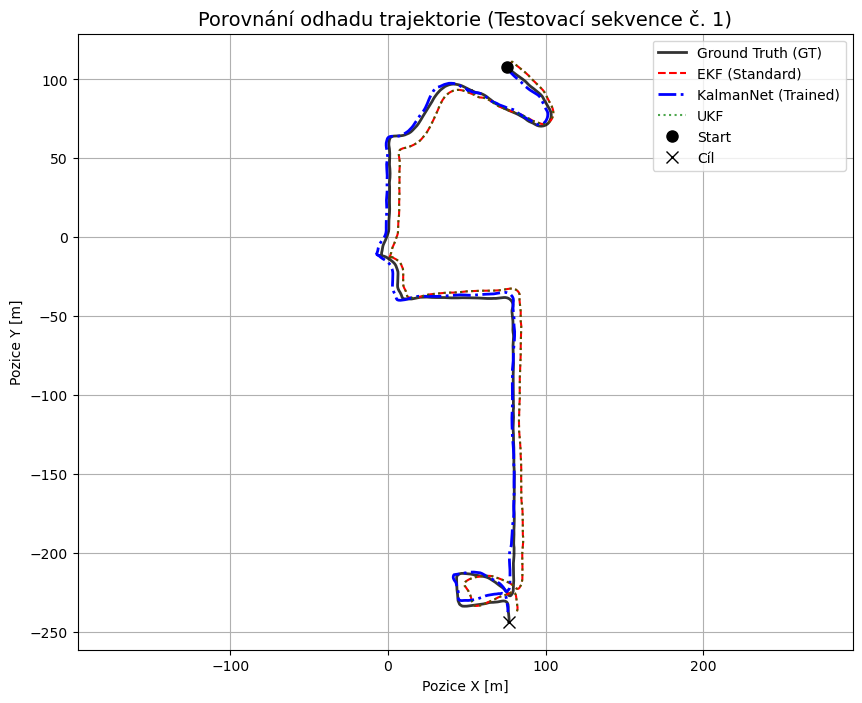

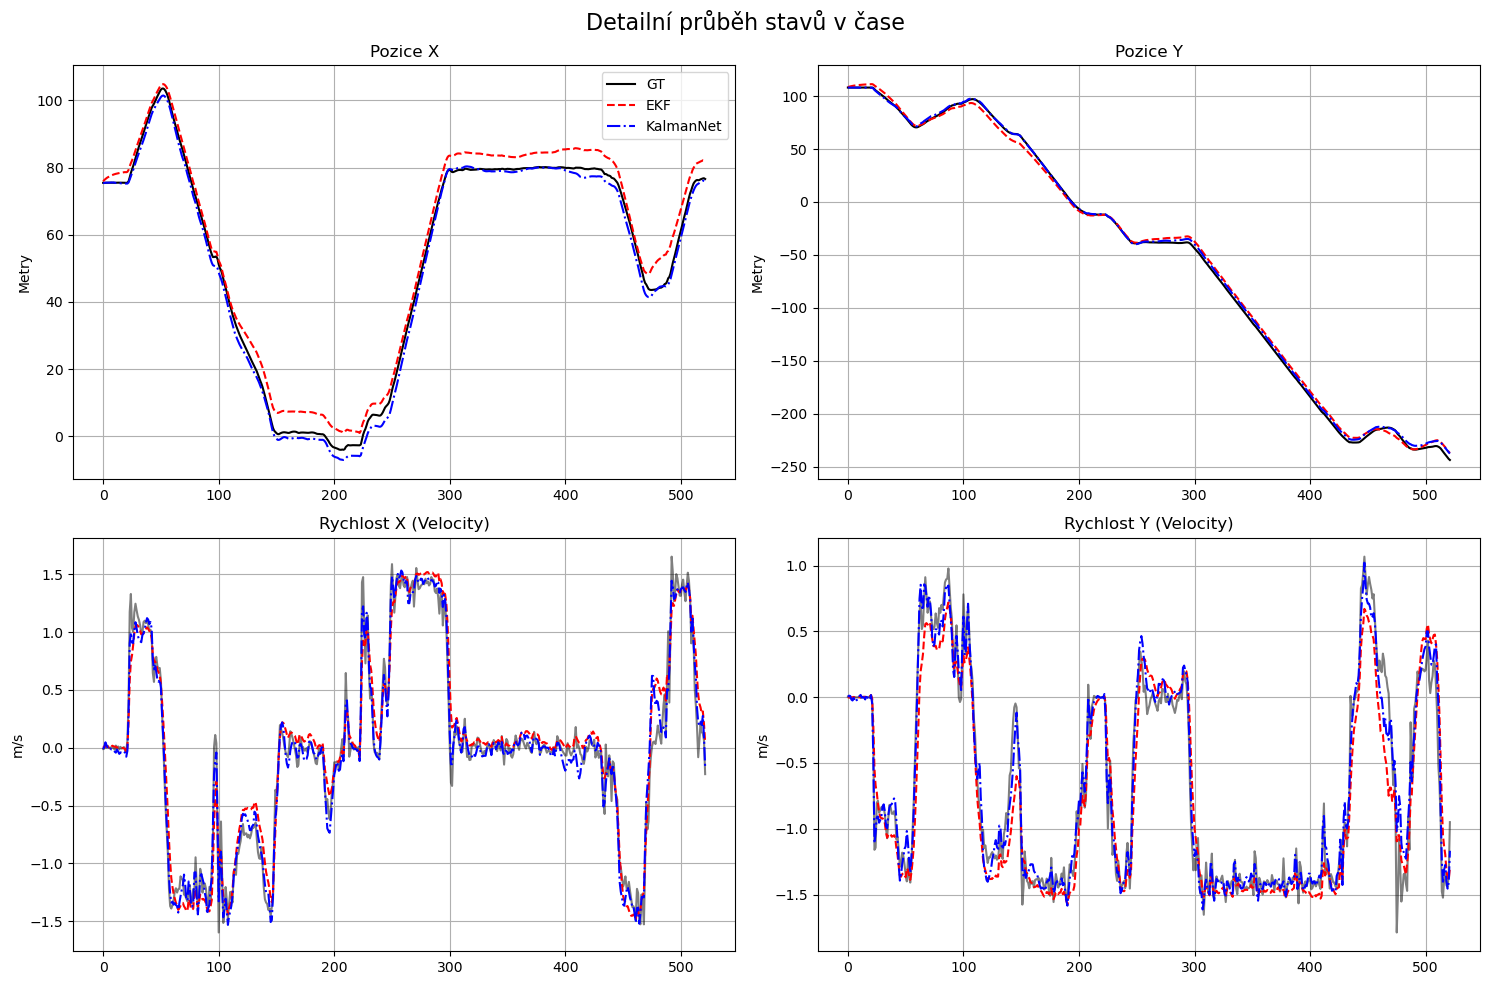

In [ ]:
import matplotlib.pyplot as plt

# === VIZUALIZACE POSLEDNÍ TESTOVACÍ TRAJEKTORIE ===

# 1. Převod tenzorů na NumPy pole (pro vykreslování)
# Bereme data z poslední iterace předchozí smyčky
gt_np = x_true.cpu().numpy()
knet_np = full_x_hat_knet.cpu().numpy()
ekf_np = full_x_hat_ekf.cpu().numpy()
# (Pokud chceš i UKF, odkomentuj:)
ukf_np = full_x_hat_ukf.cpu().numpy()

# Časová osa (kroky)
time_steps = np.arange(gt_np.shape[0])

# Připomínka indexů (Author's format):
# 0: Pos X, 1: Vel X, 2: Pos Y, 3: Vel Y
idx_px, idx_vx, idx_py, idx_vy = 0, 1, 2, 3

# === GRAF 1: 2D TRAJEKTORIE (MAPA) ===
plt.figure(figsize=(10, 8))
plt.title(f"Porovnání odhadu trajektorie (Testovací sekvence č. {traj_idx})", fontsize=14)

# Ground Truth
plt.plot(gt_np[:, idx_px], gt_np[:, idx_py], 'k-', linewidth=2, label='Ground Truth (GT)', alpha=0.8)

# EKF
plt.plot(ekf_np[:, idx_px], ekf_np[:, idx_py], 'r--', linewidth=1.5, label='EKF (Standard)')

# KalmanNet
plt.plot(knet_np[:, idx_px], knet_np[:, idx_py], 'b-.', linewidth=2, label='KalmanNet (Trained)')

# (Volitelně UKF)
plt.plot(ukf_np[:, idx_px], ukf_np[:, idx_py], 'g:', linewidth=1.5, label='UKF', alpha=0.7)

# Start a Cíl
plt.plot(gt_np[0, idx_px], gt_np[0, idx_py], 'ko', markersize=8, label='Start')
plt.plot(gt_np[-1, idx_px], gt_np[-1, idx_py], 'kx', markersize=8, label='Cíl')

plt.xlabel("Pozice X [m]")
plt.ylabel("Pozice Y [m]")
plt.legend()
plt.grid(True)
plt.axis('equal') # Aby mapa nebyla deformovaná
plt.show()

# === GRAF 2: DETAILNÍ PRŮBĚHY STAVŮ ===
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Detailní průběh stavů v čase", fontsize=16)

# --- Pozice X ---
axs[0, 0].plot(time_steps, gt_np[:, idx_px], 'k-', label='GT')
axs[0, 0].plot(time_steps, ekf_np[:, idx_px], 'r--', label='EKF')
axs[0, 0].plot(time_steps, knet_np[:, idx_px], 'b-.', label='KalmanNet')
axs[0, 0].set_title("Pozice X")
axs[0, 0].set_ylabel("Metry")
axs[0, 0].grid(True)
axs[0, 0].legend()

# --- Pozice Y ---
axs[0, 1].plot(time_steps, gt_np[:, idx_py], 'k-', label='GT')
axs[0, 1].plot(time_steps, ekf_np[:, idx_py], 'r--', label='EKF')
axs[0, 1].plot(time_steps, knet_np[:, idx_py], 'b-.', label='KalmanNet')
axs[0, 1].set_title("Pozice Y")
axs[0, 1].set_ylabel("Metry")
axs[0, 1].grid(True)

# --- Rychlost X ---
axs[1, 0].plot(time_steps, gt_np[:, idx_vx], 'k-', label='GT', alpha=0.5)
axs[1, 0].plot(time_steps, ekf_np[:, idx_vx], 'r--', label='EKF')
axs[1, 0].plot(time_steps, knet_np[:, idx_vx], 'b-.', label='KalmanNet')
axs[1, 0].set_title("Rychlost X (Velocity)")
axs[1, 0].set_ylabel("m/s")
axs[1, 0].grid(True)

# --- Rychlost Y ---
axs[1, 1].plot(time_steps, gt_np[:, idx_vy], 'k-', label='GT', alpha=0.5)
axs[1, 1].plot(time_steps, ekf_np[:, idx_vy], 'r--', label='EKF')
axs[1, 1].plot(time_steps, knet_np[:, idx_vy], 'b-.', label='KalmanNet')
axs[1, 1].set_title("Rychlost Y (Velocity)")
axs[1, 1].set_ylabel("m/s")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()